In [113]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import time
import seaborn as sns
import matplotlib
import statsmodels.api as sm
import itertools
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

## Define Variables

In [84]:
username = 'GothamChess'

gms = ["blitz", "bullet", "rapid"]

while True: 
    print('Please input a game mode from the following: Blitz, Rapid, Bullet')
    game_mode = input().lower()
    if game_mode in gms: 
        break
    else: 
        print('Incorrect game mode entered.')
            
#game_mode = 'blitz'

Please input a game mode from the following: Blitz, Rapid, Bullet


 afsd


Incorrect game mode entered.
Please input a game mode from the following: Blitz, Rapid, Bullet


 Blitz


## Pull Data up to and including Aug 2021

In [10]:
date = []
rating = []
result = []
time_class = []

# For each month in 2021 so far...
for i in range(1,9):
    # get the stats each month for username
    response = requests.get('https://api.chess.com/pub/player/{}/games/2021/0{}'.format(username,i))
    # for each game, if rated get data and add to lists
    for game in response.json()['games']:
        if game['rated'] == True:
            date.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(game['end_time'])))
            time_class.append(game['time_class'])
            if game['white']['username'] == 'Praisedisun':
                rating.append(game['white']['rating'])
                result.append(game['white']['result'])
            else:
                rating.append(game['black']['rating'])
                result.append(game['black']['result'])
        else:
            pass

In [11]:
df = pd.DataFrame({
    'date':date,
    'rating':rating,
    'result':result,
    'time_class':time_class
})

In [16]:
# Some date formatting
df['date'] = pd.to_datetime(df['date'])
df['timestamp'] = df['date']
df['date'] = df['date'].dt.normalize()

## Get AVG # of games played by gamemode by day

In [21]:
for mode in df['time_class'].unique():
        if mode == 'blitz':
            df_tmp = df[df['time_class']==mode]
            blitz_avg = df_tmp.resample('D', on='date').count()['date'].sum()/(len(df_tmp.resample('D', on='date').count()))
        elif mode == 'rapid':
            df_tmp =df[df['time_class'] ==mode]
            rapid_avg = df_tmp.resample('D', on='date').count()['date'].sum()/(len(df_tmp.resample('D', on='date').count()))
        elif mode == 'bullet': 
            df_tmp =df[df['time_class'] ==mode]
            bullet_avg = df_tmp.resample('D', on='date').count()['date'].sum()/(len(df_tmp.resample('D', on='date').count()))
        else: 
            print('ERROR: no time_class')

In [36]:
print('2021 AVG games per day for {}\n'.format(username),
        'Blitz AVG games per day: {}\n'.format(round(blitz_avg)),
        'Rapid AVG games per day: {}\n'.format(round(rapid_avg,2)),
        'Bullet AVG games per day: {}'.format(round(bullet_avg)))

2021 AVG games per day for GothamChess
 Blitz AVG games per day: 11
 Rapid AVG games per day: 0.23
 Bullet AVG games per day: 2


## Generate visualization

In [42]:
# Define game mode of interest (blitz,rapid,bullet)
game_mode = 'blitz'

In [43]:
dates = matplotlib.dates.date2num(df[df['time_class']==game_mode]['date'])

In [60]:
df.sort_values(by="timestamp").drop_duplicates(subset=["date"], keep="last")

,date,rating,result,time_class,timestamp
27,2021-01-01,2509,win,blitz,2021-01-01 21:32:29
38,2021-01-02,2549,win,blitz,2021-01-02 14:50:22
52,2021-01-03,2527,resigned,blitz,2021-01-03 23:12:34
71,2021-01-04,2543,resigned,blitz,2021-01-04 02:18:41
76,2021-01-05,2517,checkmated,blitz,2021-01-05 18:07:47
...,...,...,...,...,...
2858,2021-07-14,2459,timeout,blitz,2021-07-14 20:05:26
2861,2021-07-17,2744,resigned,bullet,2021-07-17 16:00:35
2879,2021-08-02,2637,win,blitz,2021-08-02 17:19:09
2893,2021-08-03,2535,win,blitz,2021-08-03 18:49:08


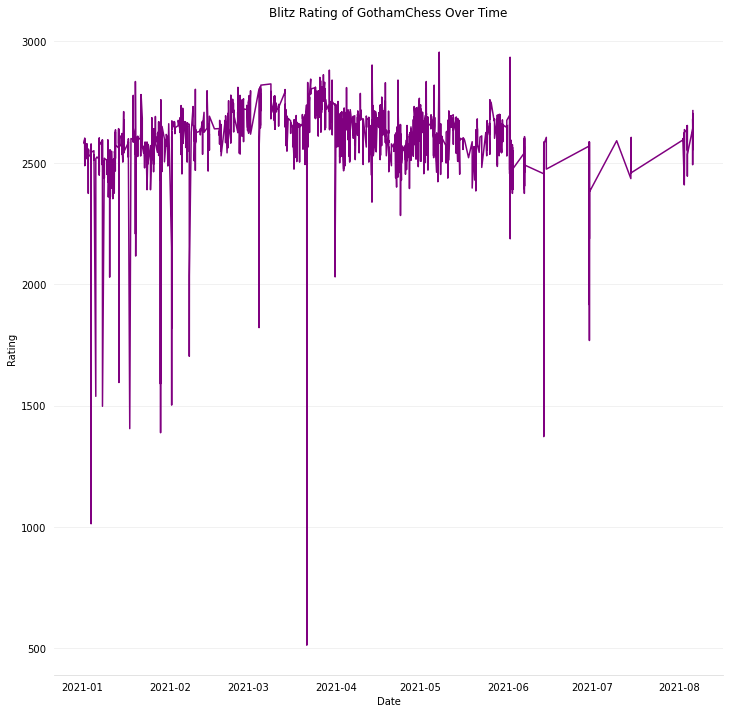

In [104]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.plot(df[df['time_class']==game_mode]['timestamp'],
       df[df['time_class']==game_mode]['rating'],
       color='purple')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)

ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Rating",
       title="{} Rating of {} Over Time".format(game_mode.capitalize(),username))

plt.show()

## Forecast average rating per day

As it is hard to forecast with timestamps (i.e. issues arise in defining the next time period when the timestamps follow no order), I decided to take the average rating per day

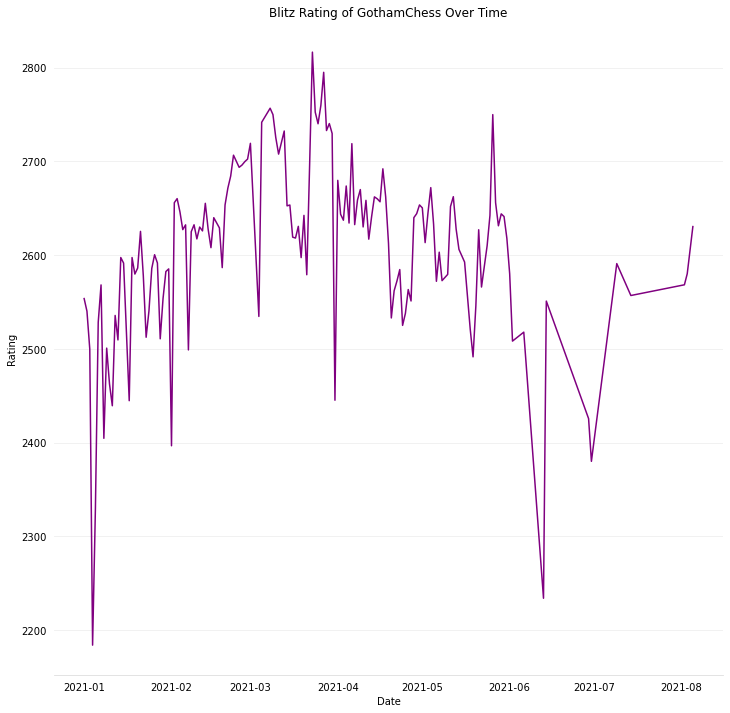

In [105]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.plot(df[df['time_class']==game_mode].groupby('date').count().index,
       df[df['time_class']==game_mode].groupby('date').mean()['rating'],
       color='purple')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)

ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)


# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Rating",
       title="{} Rating of {} Over Time".format(game_mode.capitalize(),username))

plt.show()

In [131]:
data = df[df['time_class']==game_mode].groupby('date').mean()['rating']

## Time Series Forecast

Before conducting a forecast, I must first determine whether the series is stationary or not in order to meet the assumptions of ARIMA models.

The ACF also shows the series is already fairly stationary due to the consistency of the insignificant autocorrelation past lag 10

A dickey Fuller test can perform a statistical test to determine if the time series is non-stationary. The null hypothesis of the Augmented Dickey Fuller test is that the series is non-stationary. 

In [132]:
from statsmodels.tsa.stattools import adfuller
result =adfuller(data)

In [133]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.430443
p-value: 0.009964


The p-value is <0.01 meaning that we have strong evidence to reject the null that the data is non-stationary.

This would suggest that no differencing is required

## AR Order

The PACF can suggest the number of lags to include in the ARIMA Model 

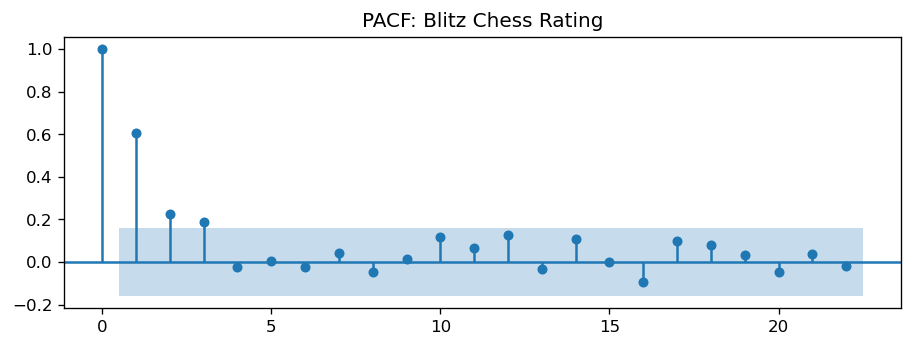

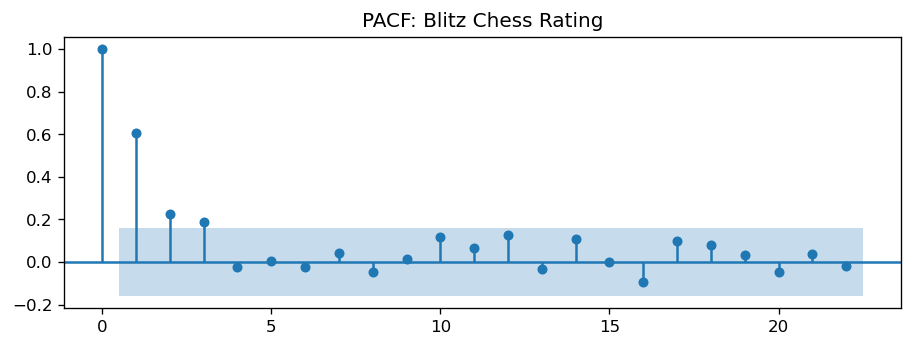

In [146]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(data, title='PACF: {} Chess Rating'.format(game_mode.capitalize()))

From the PACF, we see that it may be worth including up to 4 lags

## MA Order

The ACF/Correllogram suggests the order of the MA term

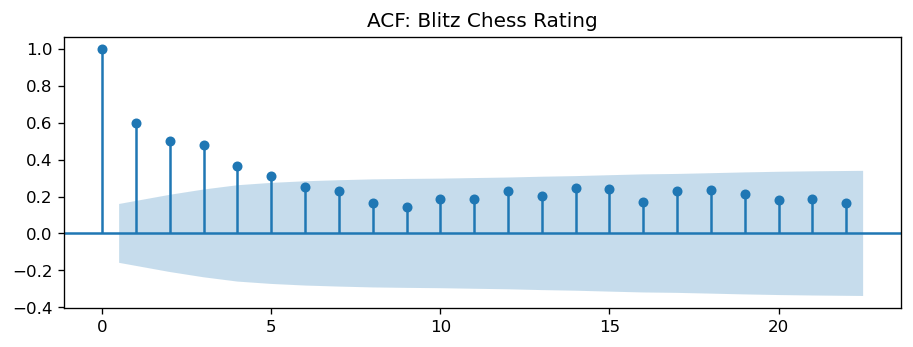

In [148]:
plot_acf(data, title='ACF: {} Chess Rating'.format(game_mode.capitalize()))

plt.show()

The ACF suggest an MA order of 5

Note, upon trying to run the model 4,0,5 I was met with a ValueError

ValueError: The computed initial AR coefficients are not stationary You should induce stationarity, choose a different model order, or you can pass your own start_params.

Given this error, I decided to difference the data to analyse the results below

In [164]:
model = ARIMA(data.values, order=(4,1,5))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())

/Users/joshwoodbridge/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  150
Model:                 ARIMA(4, 1, 5)   Log Likelihood                -855.525
Method:                       css-mle   S.D. of innovations             71.272
Date:                Sun, 08 Aug 2021   AIC                           1733.049
Time:                        19:08:55   BIC                           1766.166
Sample:                             1   HQIC                          1746.504
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2422      0.445      0.544      0.587      -0.631       1.115
ar.L1.D.y      1.7410        nan        nan        nan         nan         nan
ar.L2.D.y     -1.5542      0.006   -269.488      0.0

/Users/joshwoodbridge/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/joshwoodbridge/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/joshwoodbridge/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and con

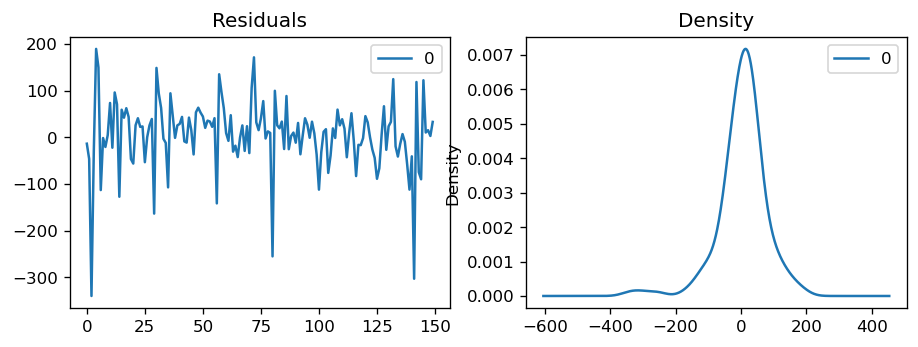

In [161]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

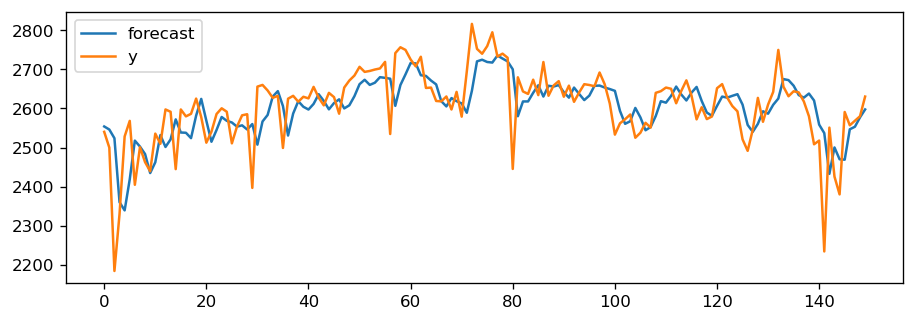

In [165]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [183]:
data[85:]

date
2021-04-04    2673.800000
2021-04-05    2634.285714
2021-04-06    2719.000000
2021-04-07    2632.583333
2021-04-08    2658.920000
                 ...     
2021-07-09    2591.000000
2021-07-14    2556.950000
2021-08-02    2568.388889
2021-08-03    2580.142857
2021-08-05    2630.500000
Name: rating, Length: 66, dtype: float64

In [197]:
# Create Training and Test
train = data[:110]
test = data[110:]

/Users/joshwoodbridge/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/joshwoodbridge/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/joshwoodbridge/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima

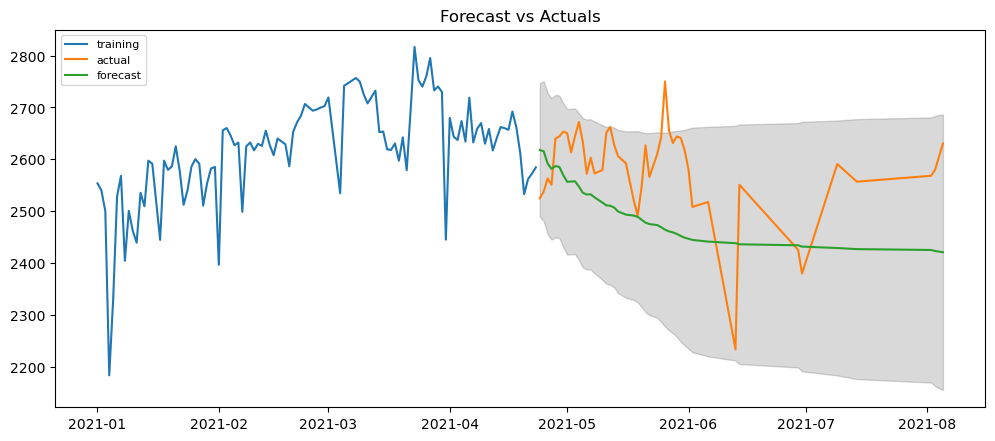

In [201]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(4,1,5))  
fitted = model.fit(disp=0)  

# Forecast
fc, se, conf = fitted.forecast(46, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()